<a href="https://colab.research.google.com/github/jeetnakrani/ShapeAI_Bootcamp_BWD/blob/main/Copy_of_Emoji_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [92]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import time
import openpyxl
from pathlib import Path


In [93]:
import nltk
import re
nltk.download("stopwords")
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from wordcloud import WordCloud, STOPWORDS

from textblob import TextBlob

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [94]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [95]:
df = pd.read_excel("/content/111.xlsx")
df.head(10)

,ID,Type,Priority,Status,Survey,Associated Survey Sentiment,Associated Survey Short Text Response
0,INC-573356,Incident,Medium,Closed,Positive,happy,good
1,INC-574724,Incident,Medium,Closed,Positive,happy,excellent
2,INC-410436,Incident,Medium,Closed,Positive,happy,Done good
3,INC-400111,Incident,Medium,Closed,Positive,happy,good
4,INC-441421,Incident,Medium,Closed,Positive,happy,Ok work is done thanks for support
5,INC-453619,Incident,Medium,Closed,Positive,happy,Thanks a ton
6,INC-530067,Incident,Medium,Closed,Positive,happy,Quick response
7,INC-443466,Incident,Medium,Closed,Positive,happy,Good support
8,INC-531901,Incident,Medium,Closed,Positive,happy,Thank you..
9,INC-527366,Incident,Medium,Closed,Positive,happy,good


In [96]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6862 entries, 0 to 6861
Data columns (total 7 columns):
 #   Column                                 Non-Null Count  Dtype 
---  ------                                 --------------  ----- 
 0   ID                                     6862 non-null   object
 1   Type                                   6862 non-null   object
 2   Priority                               6862 non-null   object
 3   Status                                 6862 non-null   object
 4   Survey                                 6862 non-null   object
 5   Associated Survey Sentiment            6862 non-null   object
 6   Associated Survey Short Text Response  6851 non-null   object
dtypes: object(7)
memory usage: 375.4+ KB


In [97]:
df.describe()

,ID,Type,Priority,Status,Survey,Associated Survey Sentiment,Associated Survey Short Text Response
count,6862,6862,6862,6862,6862,6862,6851
unique,6862,2,4,4,3,2,5822
top,INC-573356,Incident,Medium,Closed,Positive,happy,Thanks for support
freq,1,4687,4244,6641,6016,6022,21


In [98]:
df.columns = ["_".join(name.lower().strip().split()) for name in df.columns]

In [99]:
df.head()

,id,type,priority,status,survey,associated_survey_sentiment,associated_survey_short_text_response
0,INC-573356,Incident,Medium,Closed,Positive,happy,good
1,INC-574724,Incident,Medium,Closed,Positive,happy,excellent
2,INC-410436,Incident,Medium,Closed,Positive,happy,Done good
3,INC-400111,Incident,Medium,Closed,Positive,happy,good
4,INC-441421,Incident,Medium,Closed,Positive,happy,Ok work is done thanks for support


In [100]:
def to_sentiment(survey):
    if survey in 'Negative': # negative
        return -1 
    if survey == 'Not Attended':      # neutral
        return 0
    if survey in 'Positive': # positive
        return 1
    
# convert star rating into sentiment
df['sentiment'] = df['survey'].apply(lambda survey: to_sentiment(survey=survey))
df.drop("survey",axis = 1,inplace = True)

In [101]:
df.isnull().sum()

id                                        0
type                                      0
priority                                  0
status                                    0
associated_survey_sentiment               0
associated_survey_short_text_response    11
sentiment                                 0
dtype: int64

In [102]:
model_target = "sentiment"
model_features = df.columns.drop("sentiment")

print("Model Target: ",model_target)
print("Model Features: ",model_features)

Model Target:  sentiment
Model Features:  Index(['id', 'type', 'priority', 'status', 'associated_survey_sentiment',
       'associated_survey_short_text_response'],
      dtype='object')


In [103]:
numerical_features_all = df[model_features].select_dtypes(include=np.number).columns
print('Numerical columns:',numerical_features_all)

print('')

categorical_features_all = df[model_features].select_dtypes(include='object').columns
print('Categorical columns:',categorical_features_all)

Numerical columns: Index([], dtype='object')

Categorical columns: Index(['id', 'type', 'priority', 'status', 'associated_survey_sentiment',
       'associated_survey_short_text_response'],
      dtype='object')


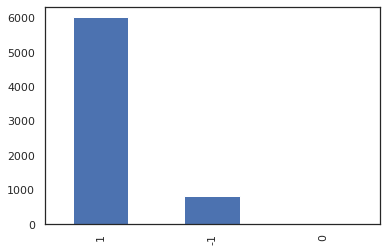

In [104]:
df[model_target].value_counts().plot.bar()
plt.show()

In [105]:
df[model_target].value_counts(normalize=True)

 1    0.876712
-1    0.121830
 0    0.001457
Name: sentiment, dtype: float64

In [106]:
for c in categorical_features_all: 
    print(df[c].value_counts())

INC-573356    1
INC-502377    1
INC-538796    1
INC-555038    1
INC-530666    1
             ..
INC-506127    1
INC-404603    1
INC-516348    1
INC-518746    1
INC-571865    1
Name: id, Length: 6862, dtype: int64
Incident           4687
Service Request    2175
Name: type, dtype: int64
Medium    4244
Low       2613
High         3
Urgent       2
Name: priority, dtype: int64
Closed      6641
Resolved     212
Hold           8
Open           1
Name: status, dtype: int64
happy      6022
unhappy     840
Name: associated_survey_sentiment, dtype: int64
Thanks for support                              21
Ok Done                                         14
THANK YOU                                       14
good                                            13
Good support                                    13
                                                ..
concer resolve                                   1
Not required.                                    1
work of whole team of IT is excellent     

type


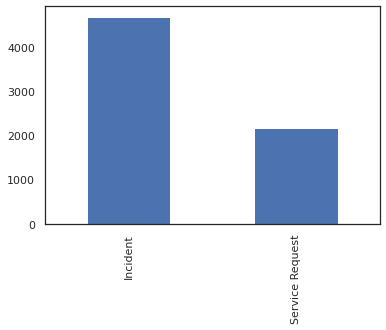

priority


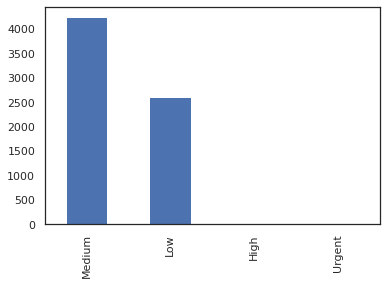

status


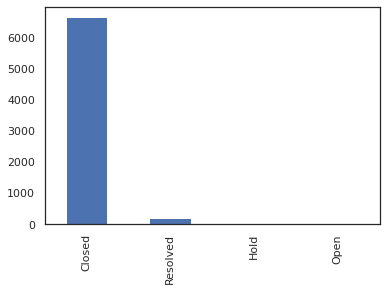

associated_survey_sentiment


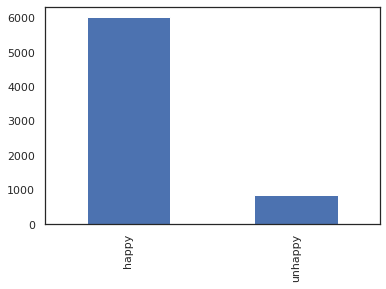

In [160]:
for c in categorical_features_all:
    if len(df[c].value_counts()) < 50:
        print(c)
        df[c].value_counts().plot.bar()
        plt.show()

In [161]:
final_df = df[["associated_survey_short_text_response","sentiment"]]
final_df.dropna(inplace = True)

final_df.isnull().sum()

/usr/local/lib/python3.8/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


associated_survey_short_text_response    0
sentiment                                0
dtype: int64

In [162]:
final_df.head()

,associated_survey_short_text_response,sentiment
0,good,1
1,excellent,1
2,Done good,1
3,good,1
4,Ok work is done thanks for support,1


In [163]:
final_df.associated_survey_short_text_response[1765]

'Very much Agile..'

In [164]:
print(f"Dataset Shape: {final_df.shape}")

Dataset Shape: (6851, 2)


In [165]:
final_df[final_df.duplicated()]

,associated_survey_short_text_response,sentiment
3,good,1
9,good,1
55,ok,1
61,good,1
66,KEEP IT UP,1
...,...,...
6830,Ty,1
6833,Good & fAST WORK,1
6835,Thanks for instant support,1
6843,swift support,1


In [166]:
final_df.drop_duplicates(inplace = True)
final_df[final_df.duplicated()]

/usr/local/lib/python3.8/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


,associated_survey_short_text_response,sentiment


In [167]:
print(f"Dataset Shape: {final_df.shape}")

Dataset Shape: (5827, 2)


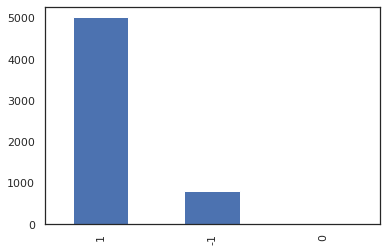

 1    5018
-1     799
 0      10
Name: sentiment, dtype: int64


In [168]:
final_df.sentiment.value_counts().plot.bar()
plt.show()
print(final_df.sentiment.value_counts())

In [169]:
convert_dict = {'associated_survey_short_text_response': str}
 
final_df = final_df.astype(convert_dict)

In [170]:

final_df['review_length'] = final_df['associated_survey_short_text_response'].apply(len)
print(final_df.shape)
final_df.head()

(5827, 3)


,associated_survey_short_text_response,sentiment,review_length
0,good,1,4
1,excellent,1,9
2,Done good,1,9
4,Ok work is done thanks for support,1,34
5,Thanks a ton,1,12


In [171]:
final_df =final_df[["associated_survey_short_text_response","sentiment","review_length"]]
final_df.head()


,associated_survey_short_text_response,sentiment,review_length
0,good,1,4
1,excellent,1,9
2,Done good,1,9
4,Ok work is done thanks for support,1,34
5,Thanks a ton,1,12


In [172]:
final_df.describe().T

,count,mean,std,min,25%,50%,75%,max
sentiment,5827.0,0.724043,0.688569,-1.0,1.0,1.0,1.0,1.0
review_length,5827.0,43.604599,42.707857,1.0,21.0,31.0,51.0,568.0


In [174]:
for i in np.unique(final_df.sentiment):
    print(np.unique(final_df.sentiment)[i])
    print(final_df[final_df.sentiment == i].review_length.value_counts(bins = 30))

1
(22.933, 39.867]      191
(39.867, 56.8]        134
(5.491, 22.933]       116
(56.8, 73.733]         99
(73.733, 90.667]       65
(90.667, 107.6]        51
(107.6, 124.533]       35
(141.467, 158.4]       21
(124.533, 141.467]     20
(175.333, 192.267]     15
(158.4, 175.333]        8
(192.267, 209.2]        8
(209.2, 226.133]        6
(310.8, 327.733]        6
(260.0, 276.933]        5
(243.067, 260.0]        3
(327.733, 344.667]      3
(276.933, 293.867]      2
(293.867, 310.8]        2
(446.267, 463.2]        2
(226.133, 243.067]      1
(344.667, 361.6]        1
(378.533, 395.467]      1
(412.4, 429.333]        1
(463.2, 480.133]        1
(480.133, 497.067]      1
(497.067, 514.0]        1
(361.6, 378.533]        0
(395.467, 412.4]        0
(429.333, 446.267]      0
Name: review_length, dtype: int64
-1
(20.8, 22.2]                 2
(3.9570000000000003, 5.4]    1
(19.4, 20.8]                 1
(39.0, 40.4]                 1
(36.2, 37.6]                 1
(26.4, 27.8]              

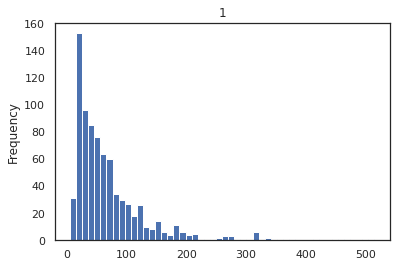

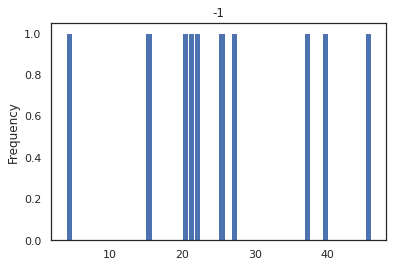

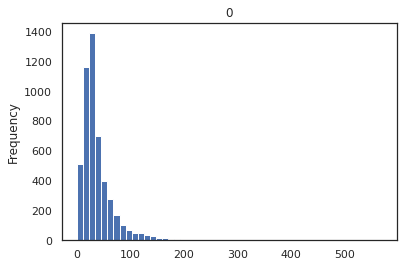

In [175]:
for i in np.unique(final_df.sentiment):
    final_df[final_df.sentiment == i].review_length.plot.hist(bins = 50)
    plt.title(np.unique(final_df.sentiment)[i])
    plt.show()

In [176]:
final_df['polarity'] = final_df['associated_survey_short_text_response'].apply(lambda x: TextBlob(x).sentiment.polarity)
final_df.head(5)

,associated_survey_short_text_response,sentiment,review_length,polarity
0,good,1,4,0.70
1,excellent,1,9,1.00
2,Done good,1,9,0.70
4,Ok work is done thanks for support,1,34,0.35
5,Thanks a ton,1,12,0.20


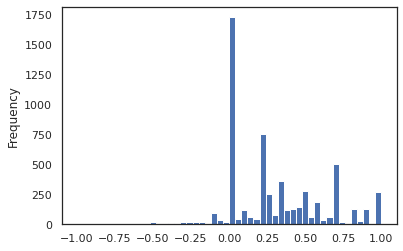

In [177]:
final_df.polarity.plot.hist(bins=50)
plt.show()

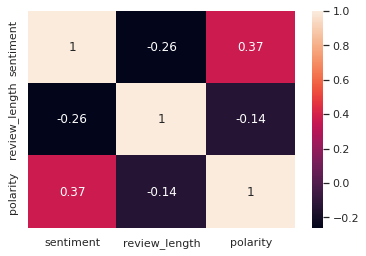

In [178]:
sns.heatmap(final_df.corr(),annot=True,fmt='.2g')

In [184]:
def CloudWord(column):
  comment_words = ''
  stopwords = set(STOPWORDS)
  
  # iterate through the csv file
  for val in df[column]:
      # typecaste each val to string
      val = str(val)
      # split the value
      tokens = val.split()
      # Converts each token into lowercase
      for i in range(len(tokens)):
          tokens[i] = tokens[i].lower()
      comment_words += " ".join(tokens)+" "
  wordcloud = WordCloud(width = 800, height = 800,
                  background_color ='white',
                  stopwords = stopwords,
                  min_font_size = 10).generate(comment_words)
  
  # plot the WordCloud image                      
  plt.figure(figsize = (8, 8), facecolor = None)
  plt.imshow(wordcloud)
  plt.title(f"Most Common Words in The {column.upper()} column \n")
  plt.axis("off")
  plt.tight_layout(pad = 0)
  
  plt.show()

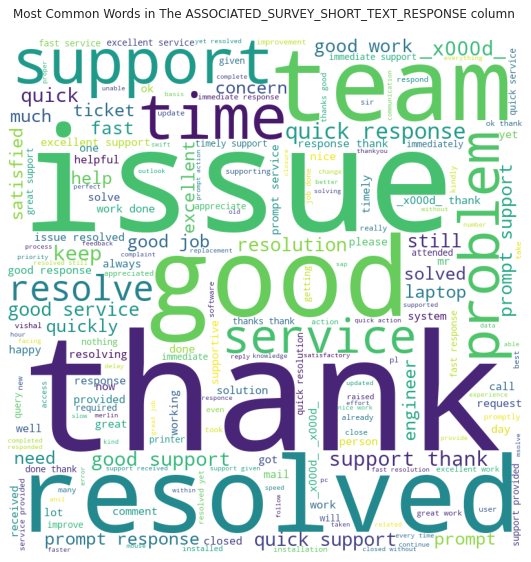

In [185]:
CloudWord("associated_survey_short_text_response")

In [186]:
snow_stemmer = SnowballStemmer(language='english')
def preprocess_text(data):
    review = re.sub('[^a-zA-Z]', ' ', data)
    review = review.lower()
    review = review.split()
    
    review = [snow_stemmer.stem(word) for word in review if not word in stopwords.words('english')] # Remove the stopwords
    review = ' '.join(review)
    return review

In [187]:
X = final_df["associated_survey_short_text_response"]
y = final_df["sentiment"]

X = X.apply(preprocess_text)

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state = 42 )

print('Datasets shapes: ', X_train.shape, X_test.shape)

Datasets shapes:  (4078,) (1749,)


In [188]:
X_train.head()

5791                    good respons new updat share user
649                             auto resolv respons quick
5572    thank quick kind support help get back work earli
4114                                           thank maam
493                                        concern resolv
Name: associated_survey_short_text_response, dtype: object

In [189]:
MAX_FEATURES = 3000
cv = CountVectorizer(max_features=MAX_FEATURES)
X_trainds = cv.fit_transform(X_train).toarray()
X_testds = cv.transform(X_test).toarray()

In [190]:
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import f1_score, roc_auc_score,balanced_accuracy_score, classification_report, confusion_matrix

Accuracy Score 0.8707833047455689
------------------------------------------------------------
Balanced Accuracy Score 0.3333333333333333


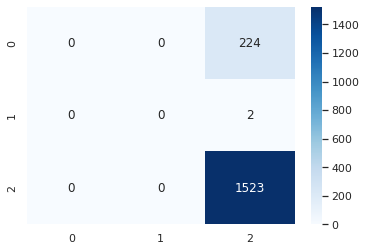

In [191]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score

dummy_clf = DummyClassifier(strategy="most_frequent").fit(X_trainds, y_train)

print("Accuracy Score",accuracy_score(y_test, dummy_clf.predict(X_testds)))
print("-"*60)
print("Balanced Accuracy Score",balanced_accuracy_score(y_test, dummy_clf.predict(X_testds)))

cm = confusion_matrix(y_test,dummy_clf.predict(X_testds))
sns.heatmap(cm,cmap='Blues',annot=True,fmt='d')
plt.show()

In [192]:
random_state = 42
classifiers = [DecisionTreeClassifier(random_state = random_state,class_weight = "balanced"),
             RandomForestClassifier(random_state = random_state),
             KNeighborsClassifier(),
             MultinomialNB()]

trained_classifier = []
acc_score_results = []
f1_score_results = []
roc_auc_score_results = []
elapsed_time = []

for model in classifiers:
    st = time.time()
    classifier = model.fit(X_trainds,y_train)
    y_pred = classifier.predict(X_testds)
    et = time.time()

    trained_classifier.append(classifier)
    acc_score_results.append(balanced_accuracy_score(y_test,y_pred))
    f1_score_results.append(f1_score(y_test,y_pred,average = 'weighted'))
    roc_auc_score_results.append(roc_auc_score(y_test,classifier.predict_proba(X_testds),multi_class='ovr')) # One-vs-rest
    elapsed_time.append(float(et-st))

In [193]:
results_df = pd.DataFrame(data = {"trained_classifier":trained_classifier,
                                  "acc_score_results":acc_score_results,
                                  "f1_score_results":f1_score_results,
                                  "roc_auc_score_results":roc_auc_score_results,
                                  "elapsed_time":elapsed_time})

In [194]:
results_df

,trained_classifier,acc_score_results,f1_score_results,roc_auc_score_results,elapsed_time
0,DecisionTreeClassifier(class_weight='balanced'...,0.535141,0.893459,0.720401,1.001042
1,"(DecisionTreeClassifier(max_features='auto', r...",0.531818,0.922157,0.782582,6.703867
2,KNeighborsClassifier(),0.478334,0.900970,0.723176,1.432920
3,MultinomialNB(),0.571471,0.932355,0.745428,0.670453


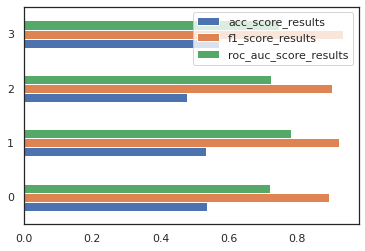

In [195]:
results_df[["acc_score_results","f1_score_results","roc_auc_score_results"]].plot.barh()
plt.show()

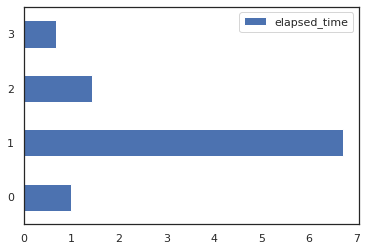

In [196]:
results_df.plot.barh(y = "elapsed_time")
plt.show()

In [197]:
for i in range(len(results_df)):
    y_pred = results_df.trained_classifier[i].predict(X_testds)
    print("\n",str(results_df.trained_classifier[i]))
    print(classification_report(y_test,y_pred))
    print("-"*90,"\n")


 DecisionTreeClassifier(class_weight='balanced', random_state=42)
              precision    recall  f1-score   support

          -1       0.65      0.71      0.68       224
           0       0.00      0.00      0.00         2
           1       0.96      0.90      0.93      1523

    accuracy                           0.87      1749
   macro avg       0.54      0.54      0.53      1749
weighted avg       0.92      0.87      0.89      1749

------------------------------------------------------------------------------------------ 


 RandomForestClassifier(random_state=42)
              precision    recall  f1-score   support

          -1       0.77      0.62      0.69       224
           0       0.00      0.00      0.00         2
           1       0.95      0.97      0.96      1523

    accuracy                           0.93      1749
   macro avg       0.57      0.53      0.55      1749
weighted avg       0.92      0.93      0.92      1749

------------------------------------

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classificat

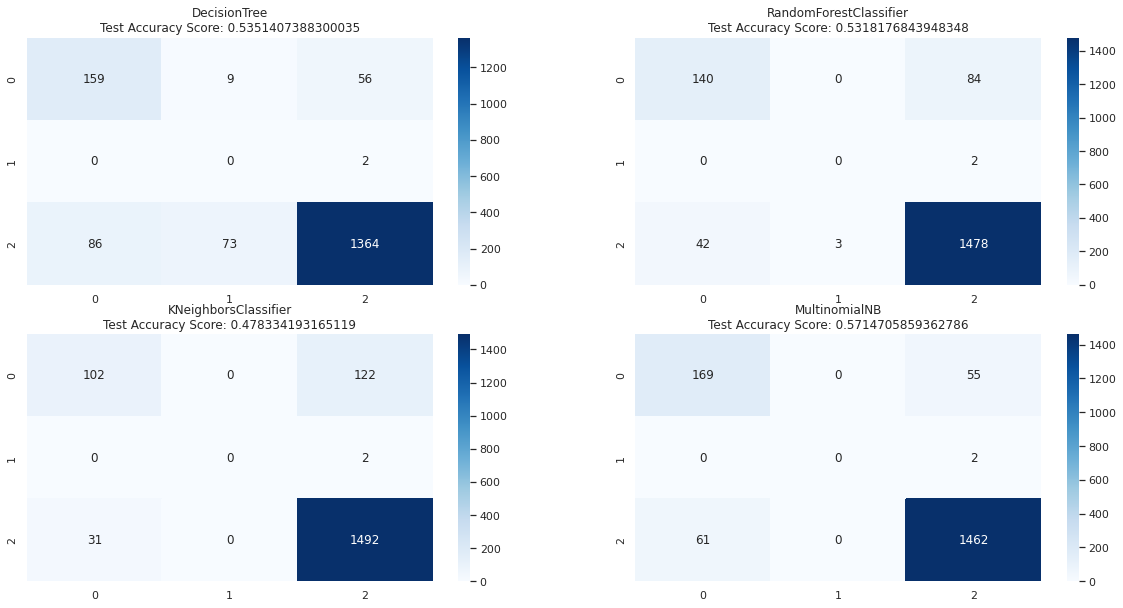

In [198]:
fig,((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(20,10))


cm_DecisionTree = confusion_matrix(y_test,results_df.trained_classifier[0].predict(X_testds))
cm_RandomForestClassifier = confusion_matrix(y_test,results_df.trained_classifier[1].predict(X_testds))
cm_KNeighborsClassifier = confusion_matrix(y_test,results_df.trained_classifier[2].predict(X_testds))
cm_MultinomialNB = confusion_matrix(y_test,results_df.trained_classifier[3].predict(X_testds))

sns.heatmap(cm_DecisionTree,cmap='Blues',annot=True,fmt='d',ax = ax1)
ax1.set_title("DecisionTree\nTest Accuracy Score: "+str(results_df.acc_score_results[0])  )

sns.heatmap(cm_RandomForestClassifier,cmap='Blues',annot=True,fmt='d',ax = ax2)
ax2.set_title("RandomForestClassifier\nTest Accuracy Score: "+str(results_df.acc_score_results[1]) )

sns.heatmap(cm_KNeighborsClassifier,cmap='Blues',annot=True,fmt='d',ax = ax3)
ax3.set_title("KNeighborsClassifier\nTest Accuracy Score: "+str(results_df.acc_score_results[2]) )

sns.heatmap(cm_MultinomialNB,cmap='Blues',annot=True,fmt='d',ax = ax4)
ax4.set_title("MultinomialNB\nTest Accuracy Score: "+str(results_df.acc_score_results[3]))

plt.show()

In [199]:
vectorizer = TfidfVectorizer()
X_trainds_tfidf = vectorizer.fit_transform(X_train).toarray()
X_testds_tfidf = vectorizer.transform(X_test).toarray()

In [200]:
X_trainds_tfidf.shape

(4078, 1880)

In [201]:
random_state = 42
classifiers = {  DecisionTreeClassifier(random_state = random_state,class_weight = "balanced"),
                 RandomForestClassifier(random_state = random_state),
                 KNeighborsClassifier(),
                 MultinomialNB()}

tf_idf_trained_classifier = []
tf_idf_acc_score_results = []
tf_idf_f1_score_results = []
tf_idf_roc_auc_score_results = []
tf_idf_elapsed_time = []

for model in classifiers:
    st = time.time()
    classifier = model.fit(X_trainds_tfidf,y_train)
    y_pred = classifier.predict(X_testds_tfidf)
    et = time.time()
    
    tf_idf_trained_classifier.append(classifier)
    tf_idf_acc_score_results.append(balanced_accuracy_score(y_test,y_pred))
    tf_idf_f1_score_results.append(f1_score(y_test,y_pred,average = 'weighted'))
    tf_idf_roc_auc_score_results.append(roc_auc_score(y_test,classifier.predict_proba(X_testds_tfidf),multi_class='ovr')) #One-vs-rest
    tf_idf_elapsed_time.append(float(et-st))

In [202]:
tf_idf_results_df = pd.DataFrame(data = {"tf_idf_trained_classifier":tf_idf_trained_classifier,
                                          "tf_idf_acc_score_results":tf_idf_acc_score_results,
                                          "tf_idf_f1_score_results":tf_idf_f1_score_results,
                                          "tf_idf_roc_auc_score_results":tf_idf_roc_auc_score_results,
                                          "tf_idf_elapsed_time":tf_idf_elapsed_time
                                            })

In [203]:
tf_idf_results_df

,tf_idf_trained_classifier,tf_idf_acc_score_results,tf_idf_f1_score_results,tf_idf_roc_auc_score_results,tf_idf_elapsed_time
0,DecisionTreeClassifier(class_weight='balanced'...,0.534222,0.895616,0.709669,2.366408
1,"(DecisionTreeClassifier(max_features='auto', r...",0.515143,0.922144,0.792935,4.525082
2,KNeighborsClassifier(),0.447785,0.887975,0.666477,1.716997
3,MultinomialNB(),0.496060,0.915241,0.747297,0.055656


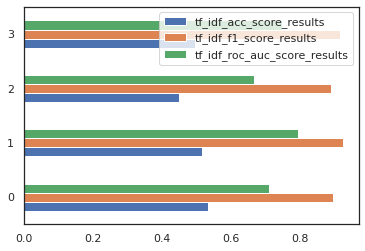

In [204]:
tf_idf_results_df[["tf_idf_acc_score_results","tf_idf_f1_score_results","tf_idf_roc_auc_score_results"]].plot.barh()

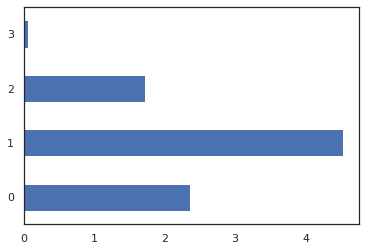

In [205]:
tf_idf_results_df.tf_idf_elapsed_time.plot.barh()

In [206]:
for i in range(len(tf_idf_results_df)):
    y_pred = tf_idf_results_df.tf_idf_trained_classifier[i].predict(X_testds_tfidf)
    print("\n",str(tf_idf_results_df.tf_idf_trained_classifier[i]))
    print(classification_report(y_test,y_pred))
    print("-"*90,"\n")


 DecisionTreeClassifier(class_weight='balanced', random_state=42)
              precision    recall  f1-score   support

          -1       0.62      0.69      0.66       224
           0       0.00      0.00      0.00         2
           1       0.95      0.91      0.93      1523

    accuracy                           0.88      1749
   macro avg       0.53      0.53      0.53      1749
weighted avg       0.91      0.88      0.90      1749

------------------------------------------------------------------------------------------ 


 RandomForestClassifier(random_state=42)
              precision    recall  f1-score   support

          -1       0.85      0.56      0.68       224
           0       0.00      0.00      0.00         2
           1       0.94      0.98      0.96      1523

    accuracy                           0.93      1749
   macro avg       0.59      0.52      0.55      1749
weighted avg       0.92      0.93      0.92      1749

------------------------------------

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classificat

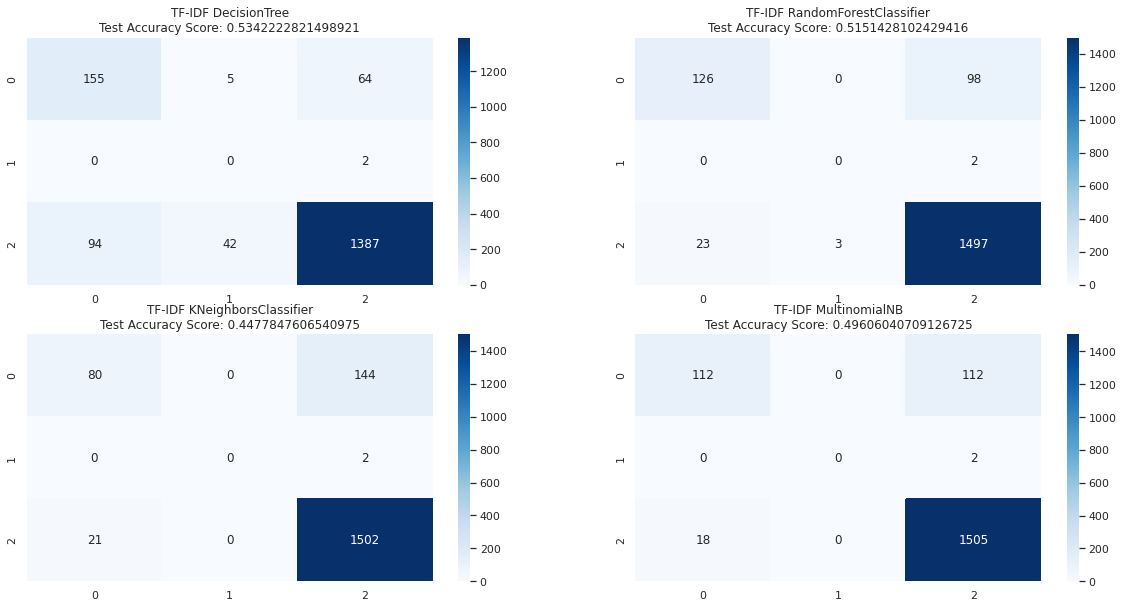

In [207]:
fig,((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(20,10))


cm_DecisionTree = confusion_matrix(y_test,tf_idf_results_df.tf_idf_trained_classifier[0].predict(X_testds_tfidf))
cm_RandomForestClassifier = confusion_matrix(y_test,tf_idf_results_df.tf_idf_trained_classifier[1].predict(X_testds_tfidf))
cm_KNeighborsClassifier = confusion_matrix(y_test,tf_idf_results_df.tf_idf_trained_classifier[2].predict(X_testds_tfidf))
cm_MultinomialNB = confusion_matrix(y_test,tf_idf_results_df.tf_idf_trained_classifier[3].predict(X_testds_tfidf))

sns.heatmap(cm_DecisionTree,cmap='Blues',annot=True,fmt='d',ax = ax1)
ax1.set_title("TF-IDF DecisionTree\nTest Accuracy Score: "+str(tf_idf_results_df.tf_idf_acc_score_results[0])  )

sns.heatmap(cm_RandomForestClassifier,cmap='Blues',annot=True,fmt='d',ax = ax2)
ax2.set_title("TF-IDF RandomForestClassifier\nTest Accuracy Score: "+str(tf_idf_results_df.tf_idf_acc_score_results[1]) )

sns.heatmap(cm_KNeighborsClassifier,cmap='Blues',annot=True,fmt='d',ax = ax3)
ax3.set_title("TF-IDF KNeighborsClassifier\nTest Accuracy Score: "+str(tf_idf_results_df.tf_idf_acc_score_results[2]) )

sns.heatmap(cm_MultinomialNB,cmap='Blues',annot=True,fmt='d',ax = ax4)
ax4.set_title("TF-IDF MultinomialNB\nTest Accuracy Score: "+str(tf_idf_results_df.tf_idf_acc_score_results[3]))

plt.show()